April: Speed of wave? Cross-sections of U, V, W, speeds. Finding speed using distance between stations and time elapsed for signal to appear in each.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

# Functions

In [2]:
def get_vars(dirname, x_ind, t_end, flag):

    fname = "1_MCKNZ_1h_20170101_201701*"
    y = slice(1,-1,None)

    if flag == 'U':
        files = general_functions.get_files(dirname, fname, 'grid_U')
        varname = 'vozocrtx'
        maskname = 'umask'
    
    elif flag == 'V':
        files = general_functions.get_files(dirname, fname, 'grid_V')
        varname = 'vomecrty'
        maskname = 'vmask'
    
    elif flag == 'W':
        files = general_functions.get_files(dirname, fname, 'grid_W')
        varname = 'vovecrtz'
        maskname = 'tmask'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    with scDataset(filesU) as dsU:
        sozotaux = dsU.variables['sozotaux'][:t_end,0,0]

    with scDataset(files) as ds:
        vel0 = ds.variables[varname][:t_end,:,y,x_ind]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            mask0 = dsM.variables[maskname][0,:,y,x_ind]

    mask = np.tile(mask0, (len(sozotaux), 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)

    return vel

In [3]:
def get_mask(dirname):
    y, x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            tmask = dsM.variables['tmask'][0,:,y,x]
            gdept = dsM.variables['gdept_1d'][0, :]
    return tmask, gdept

# Key indices x (stations) and y, z (points)

In [4]:
x_indA, x_indB, x_indC, x_indD = 170, 190, 210, 230

y_ind1, y_ind2, y_ind3 = 185, 193, 205

z_ind1, z_ind2, z_ind3 = 12, 35, 55

t_end = 4*24

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_double_muscl_partial/'

In [6]:
tmask, gdept = get_mask(dirname)

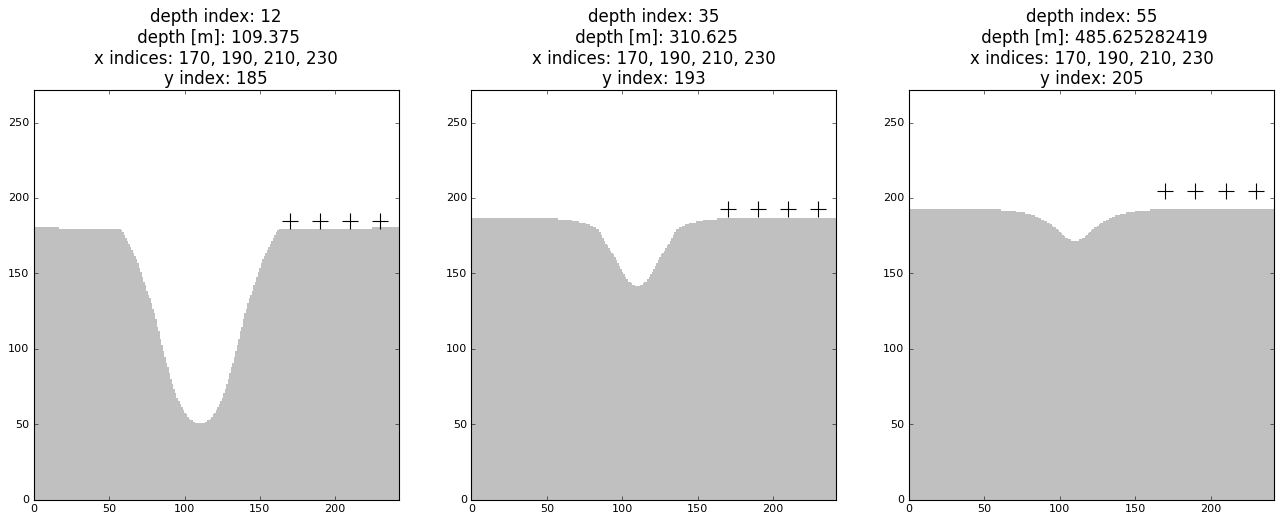

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax, dep, y_ind in zip(axes.flatten(), [z_ind1, z_ind2, z_ind3], [y_ind1, y_ind2, y_ind3]):
    cmap_land = LinearSegmentedColormap.from_list('mycmap', ['silver', 'white'])
    mask = tmask[dep, :, :]
    ax.pcolormesh(mask, cmap=cmap_land)
    ax.set_title('depth index: '+str(dep)+
                 '\n depth [m]: '+str(gdept[dep]) +
                 '\nx indices: '+str(x_indA)+', '+str(x_indB)+', '+str(x_indC)+', '+str(x_indD)+
                 '\ny index: '+str(y_ind), fontsize=15)
    ax.set_ylim([0, mask.shape[-2]])
    ax.set_xlim([0, mask.shape[-1]])
    ax.set_aspect(aspect='equal')
    
    ax.scatter(x_indA, y_ind, marker='+', c='k', s=200)
    ax.scatter(x_indB, y_ind, marker='+', c='k', s=200)
    ax.scatter(x_indC, y_ind, marker='+', c='k', s=200)
    ax.scatter(x_indD, y_ind, marker='+', c='k', s=200)

# Animation Functions

In [8]:
def calculate_speed(U_vel, V_vel):
    speed = np.sqrt(U_vel**2 + V_vel**2)
    return speed

In [9]:
def init():
    for ax, title in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
        ax.set_title(title, fontsize=20)
    return

In [10]:
def animate(time_ind):
    for ax, this_vel in zip(axes.flatten(), X_vel_all):
        ax.cla()
        p = ax.pcolormesh(this_vel[time_ind, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([0, this_vel.shape[-1]])
        ax.set_ylim([this_vel.shape[-2], 0])
        plt.suptitle('Hour: '+str(time_ind), fontsize=22)
        if time_ind == 0:
            plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.05)
        else:
            pass
        ax.scatter(y_ind1, z_ind1, c='bisque', s=100, marker='x')
        ax.scatter(y_ind2, z_ind2, c='bisque', s=100, marker='x')
        ax.scatter(y_ind3, z_ind3, c='bisque', s=100, marker='x')
    return p,

# U Velocity

In [11]:
U_velA = get_vars(dirname, x_indA, t_end, 'U')
U_velB = get_vars(dirname, x_indB, t_end, 'U')
U_velC = get_vars(dirname, x_indC, t_end, 'U')
U_velD = get_vars(dirname, x_indD, t_end, 'U')

X_vel_all = [U_velA, U_velB, U_velC, U_velD]

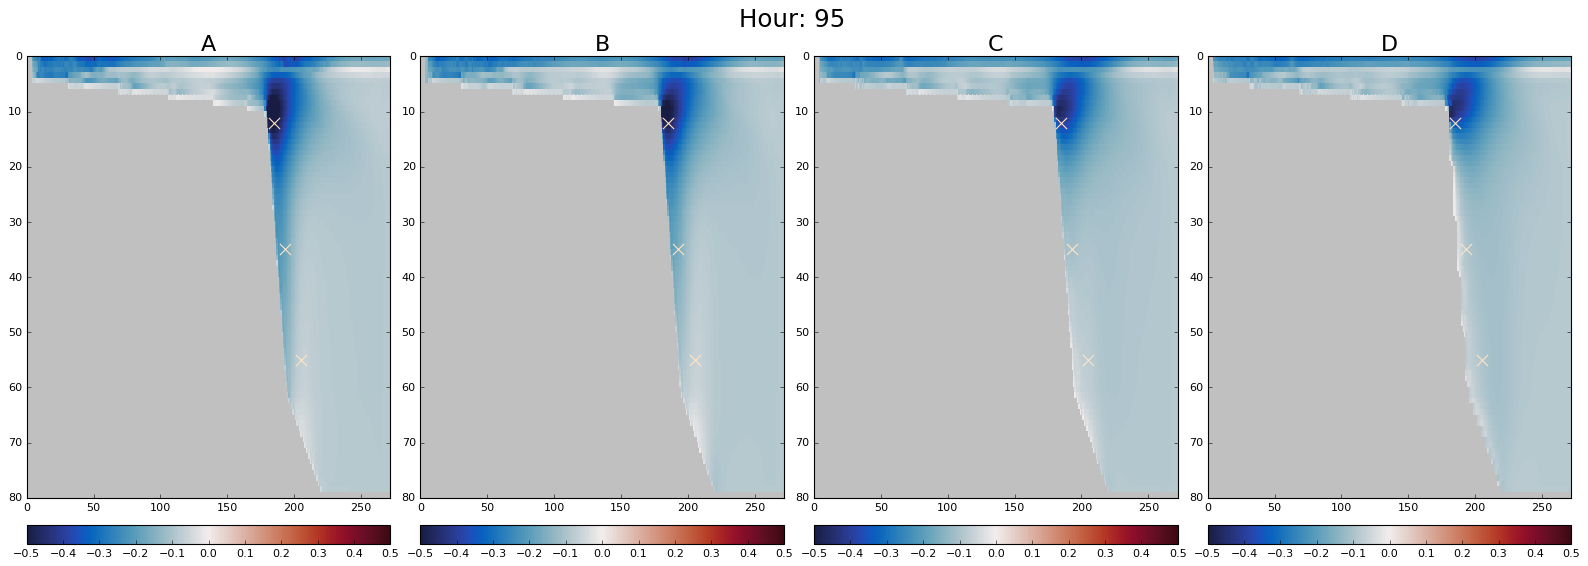

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.5, 0.5

Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('upstream_slope_U_double.mp4', writer=writer)

# V Velocity

In [12]:
V_velA = get_vars(dirname, x_indA, t_end, 'V')
V_velB = get_vars(dirname, x_indB, t_end, 'V')
V_velC = get_vars(dirname, x_indC, t_end, 'V')
V_velD = get_vars(dirname, x_indD, t_end, 'V')

X_vel_all = [V_velA, V_velB, V_velC, V_velD]

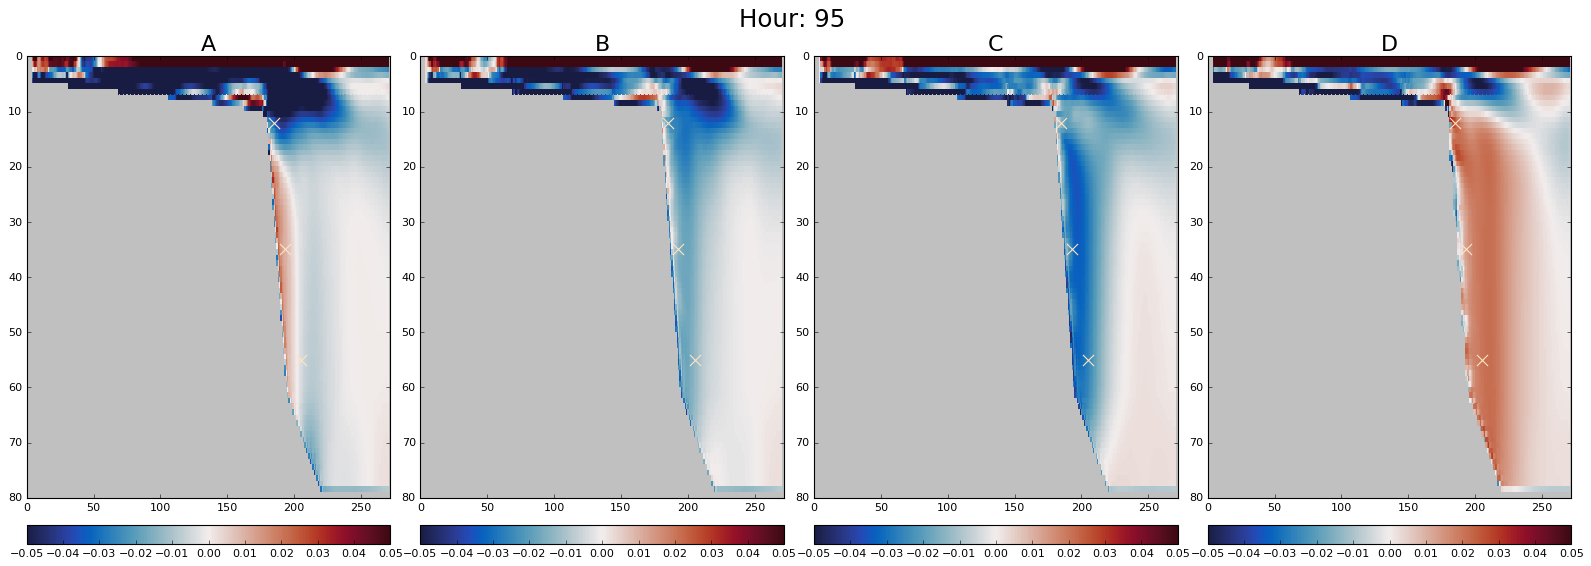

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.05, 0.05

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('upstream_slope_V_double.mp4', writer=writer)

# W Velocity

In [13]:
W_velA = get_vars(dirname, x_indA, t_end, 'W')
W_velB = get_vars(dirname, x_indB, t_end, 'W')
W_velC = get_vars(dirname, x_indC, t_end, 'W')
W_velD = get_vars(dirname, x_indD, t_end, 'W')

X_vel_all = [W_velA, W_velB, W_velC, W_velD]

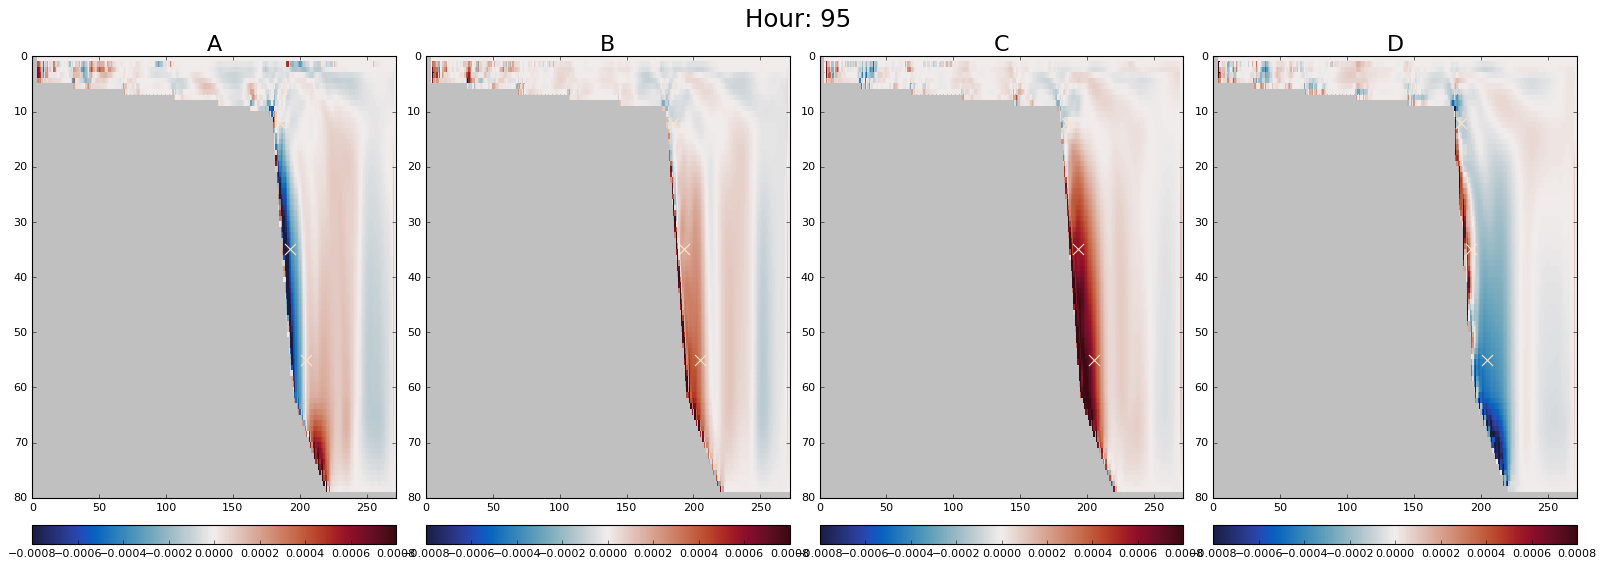

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.0008, 0.0008

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('upstream_slope_W_double.mp4', writer=writer)

# Speeds

In [14]:
speedsA = calculate_speed(U_velA, V_velA)
speedsB = calculate_speed(U_velB, V_velB)
speedsC = calculate_speed(U_velC, V_velC)
speedsD = calculate_speed(U_velD, V_velD)

X_vel_all = [speedsA, speedsB, speedsC, speedsD]

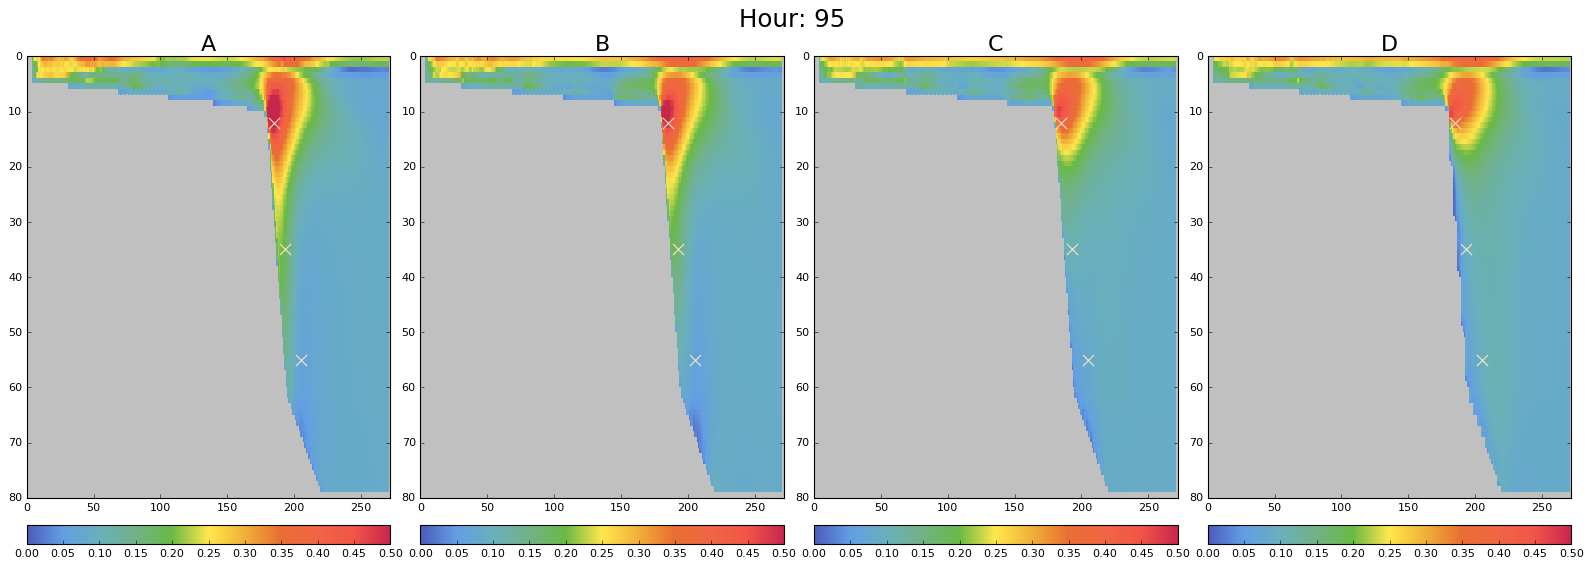

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmapIAM
cmap.set_bad('silver')
vmin, vmax = 0, 0.5

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('upstream_slope_speeds_double.mp4', writer=writer)

# Finding 3 depth points

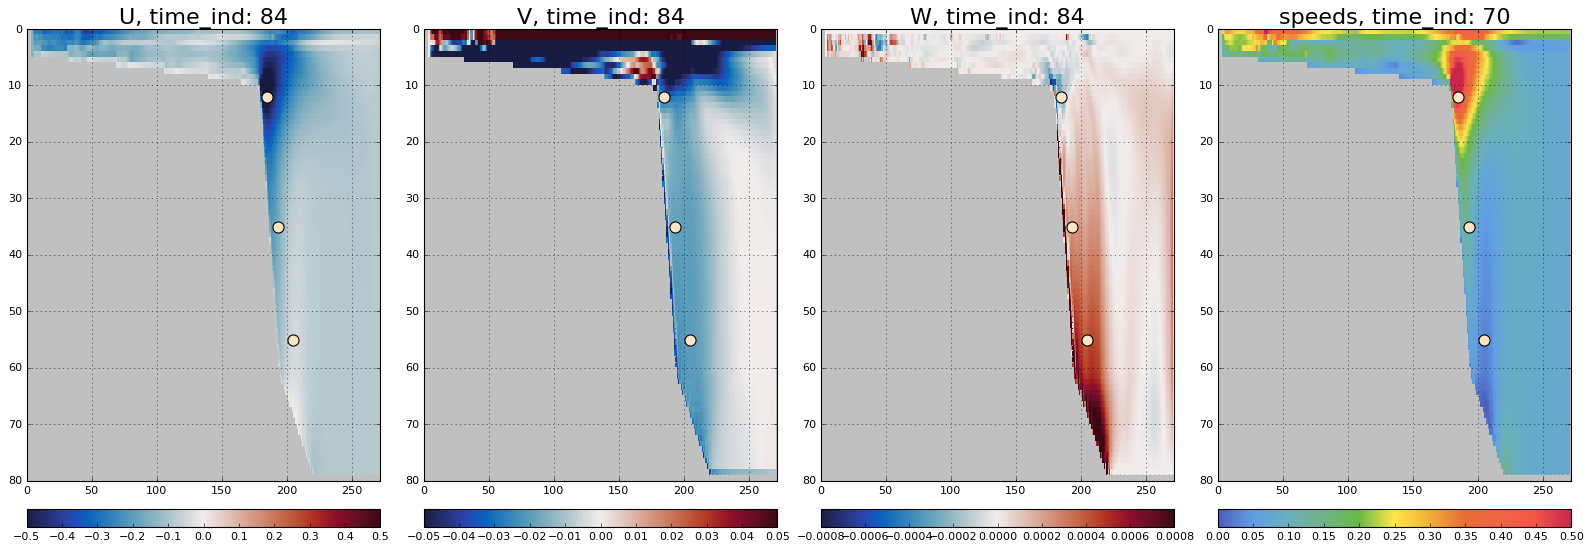

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.95])
vels = [U_velA, V_velA, W_velA, speedsA]
cmaps = [cmo.cm.balance, cmo.cm.balance, cmo.cm.balance, cmapIAM]
vmaxs = [0.5, 0.05, 0.0008, 0.5]
time_inds = [84, 84, 84, 70]
ttls = ['U', 'V', 'W', 'speeds']
for ax, this_vel, cmap, vmax, time_ind, ttl in zip(axes, vels, cmaps, vmaxs, time_inds, ttls):
    if cmap == cmapIAM:
        vmin=0
    else:
        vmin=-1*vmax
    cmap.set_bad('silver')
    p = ax.pcolormesh(this_vel[time_ind, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlim([0, this_vel.shape[-1]])
    ax.set_ylim([this_vel.shape[-2], 0])
    ax.set_title(ttl+', time_ind: '+str(time_ind), fontsize=20)
    fig.colorbar(p, ax=ax, orientation='horizontal', pad=0.05)
    ax.grid()
    # -----------------------------------------------------------------------------
    ax.scatter(y_ind1, z_ind1, c='bisque', s=100)
    ax.scatter(y_ind2, z_ind2, c='bisque', s=100)
    ax.scatter(y_ind3, z_ind3, c='bisque', s=100)
    
fig.savefig('../writing_images/wave_speed_fig14.png', dpi=100, bbox_inches='tight')

# Visualizing wave passing through the 4 stations

In [34]:
def plot_points_series(vels, ttl, order, limit_point, limit_end):
    fig, axes = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
    fig.tight_layout(h_pad=0.2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
      
    cm_times = np.linspace(0, 1, len(vels))
    colors = [cm.rainbow(x) for x in cm_times]
    z_inds = [z_ind1, z_ind2, z_ind3]
    y_inds = [y_ind1, y_ind2, y_ind3]
    npoints = np.arange(1, 4)
    
    max_vel_t_all = np.full([len(npoints), len(vels)], np.nan)
    min_vel_t_all = np.full_like(max_vel_t_all, np.nan)   
    
    for ax, z_ind, y_ind, m in zip(axes.flatten(), z_inds, y_inds, npoints):
        
        for n, vel, lab, c in zip(np.arange(len(vels)), vels, ['A', 'B', 'C', 'D'], colors):
            
            time_series = vel[:, z_ind, y_ind]
            ax.plot(time_series, label=lab, lw=2, c=c)
            
            if order=='max':
                max_vel = np.nanmax(time_series[:])
                max_vel_t = np.where(time_series == max_vel)[0][0]
                if m == limit_point:
                    min_vel = np.nanmin(time_series[max_vel_t:-limit_end])
                    min_vel_t = np.where(time_series == min_vel)[0][0]
                else:
                    min_vel = np.nanmin(time_series[max_vel_t:])
                    min_vel_t = np.where(time_series == min_vel)[0][0]
                
                
            elif order =='min':
                min_vel = np.nanmin(time_series[:])
                min_vel_t = np.where(time_series == min_vel)[0][0]
                if m == limit_point:
                    max_vel = np.nanmax(time_series[min_vel_t:-limit_end])
                    max_vel_t = np.where(time_series == max_vel)[0][0]
                else:
                    max_vel = np.nanmax(time_series[min_vel_t:])
                    max_vel_t = np.where(time_series == max_vel)[0][0]
            
            mm = m-1
            max_vel_t_all[mm, n] = max_vel_t
            min_vel_t_all[mm, n] = min_vel_t
            
            print(min_vel_t_all)
                    
            ax.scatter(max_vel_t, max_vel, s=200, marker='x', c='k', label=lab+'='+str(max_vel_t))
            ax.scatter(min_vel_t, min_vel, s=100, marker='v', c='k', label=lab+'='+str(min_vel_t))

            ax.legend(ncol=1, fontsize=14, loc=2, scatterpoints=1, bbox_to_anchor=(1, 1.1))
        ax.set_title('Point '+str(m)+': y_ind = '+str(y_ind)+', z_ind = '+str(z_ind), fontsize=18)
        ax.set_xlim([0, time_series.shape[0]])
        ml = MultipleLocator(4)
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        plt.xticks(np.arange(0, time_series.shape[0], 4))
    fig.suptitle('Time series of '+ttl+' at 4 upstream stations', fontsize=20)
    
    return fig, axes, max_vel_t_all, min_vel_t_all

[[ 63.  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  nan  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  nan]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  94.]
 [ nan  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  94.]
 [ 69.  nan  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  94.]
 [ 69.  85.  nan  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  94.]
 [ 69.  85.  95.  nan]]
[[ 63.  72.  80.  83.]
 [ 68.  77.  84.  94.]
 [ 69.  85.  95.  95.]]


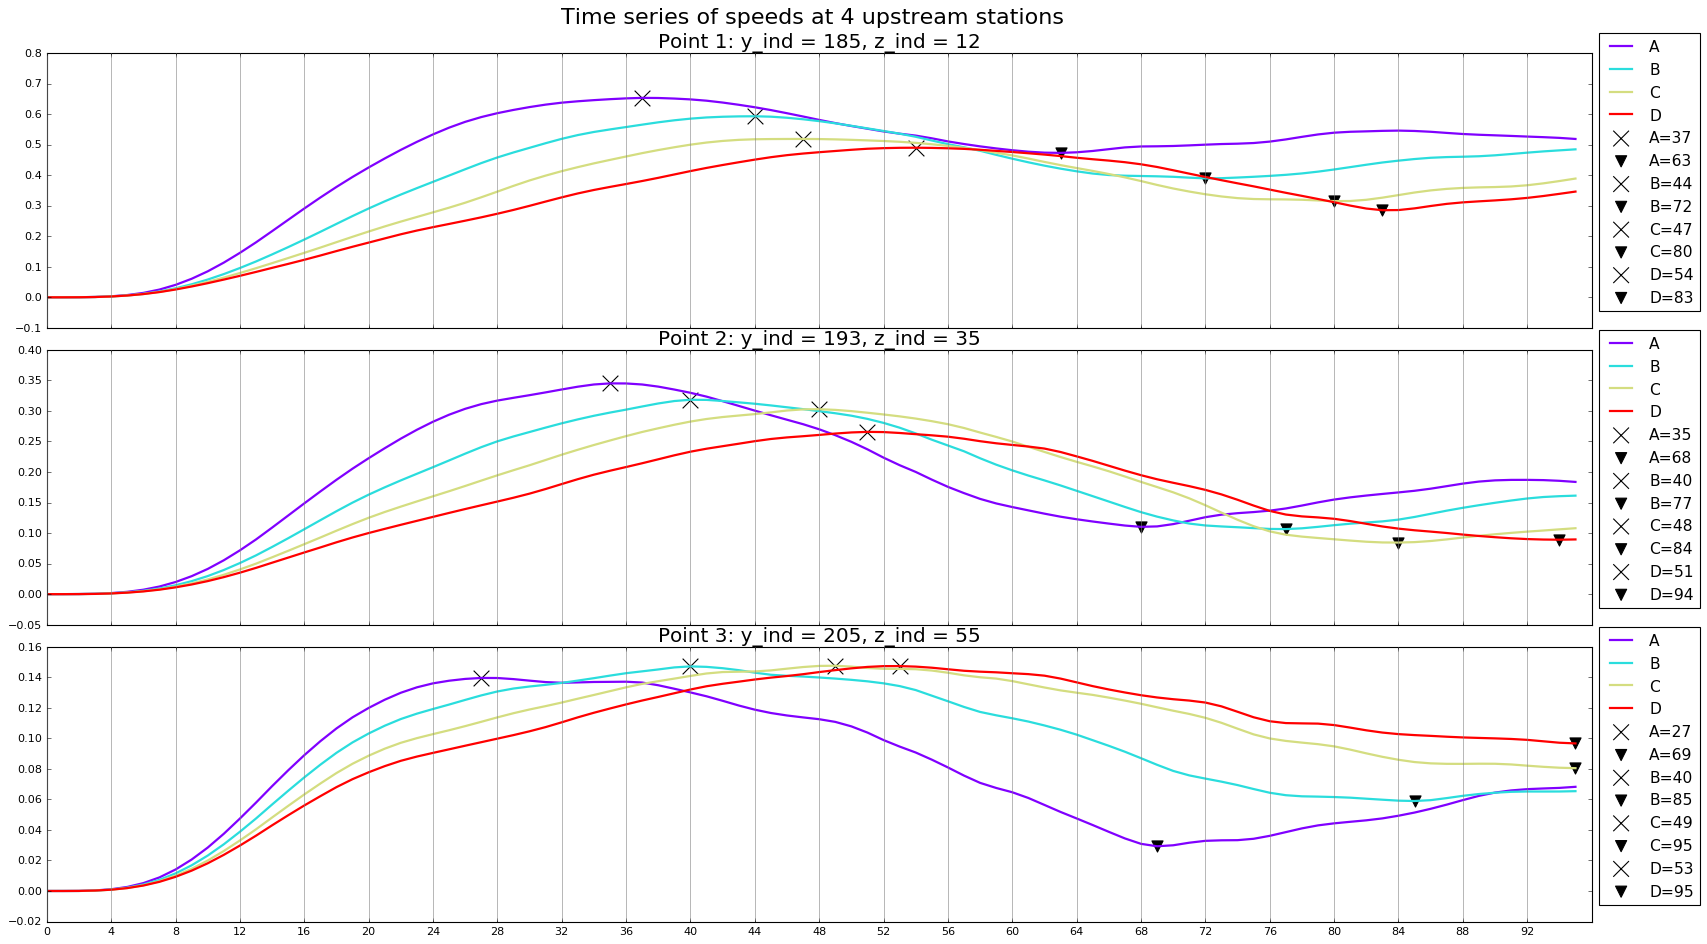

In [35]:
vels = [speedsA, speedsB, speedsC, speedsD]
fig, axes, max_vel_t_all_speeds, min_vel_t_all_speeds = plot_points_series(vels, 'speeds', 'max', 1, 1)

fig.savefig('../writing_images/wave_speed_fig15.png', dpi=100, bbox_inches='tight')

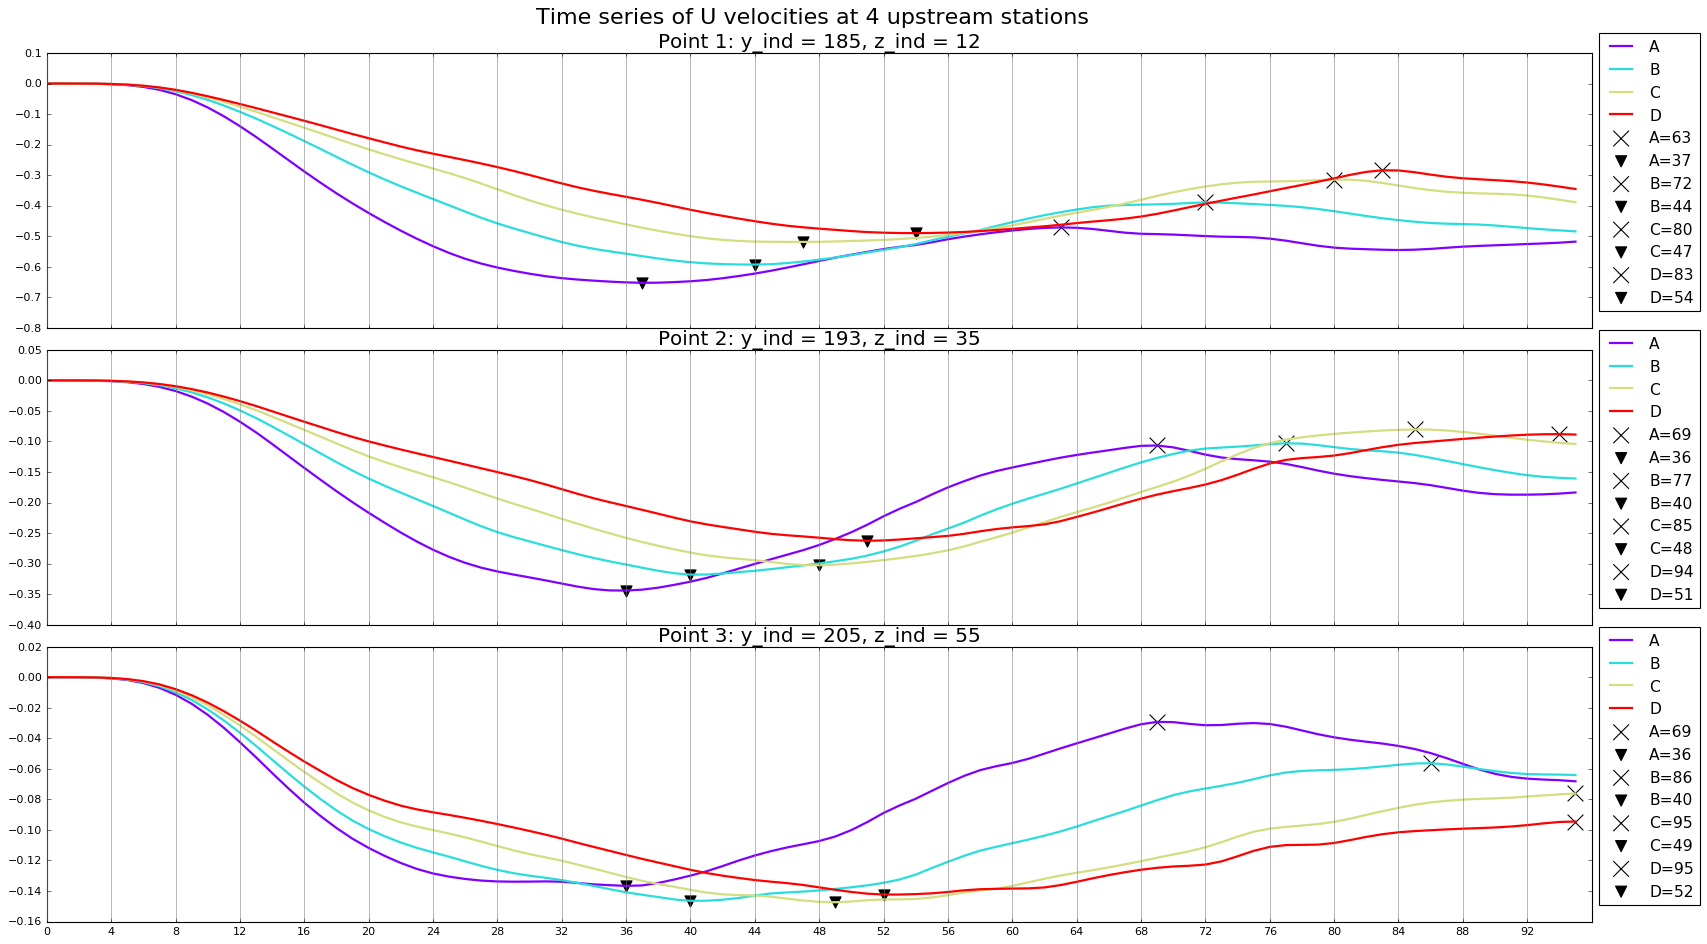

In [28]:
vels = [U_velA, U_velB, U_velC, U_velD]
fig, axes, max_vel_t_all_U, min_vel_t_all_U = plot_points_series(vels, 'U velocities', 'min', 1, 1)

fig.savefig('../writing_images/wave_speed_fig16.png', dpi=100, bbox_inches='tight')

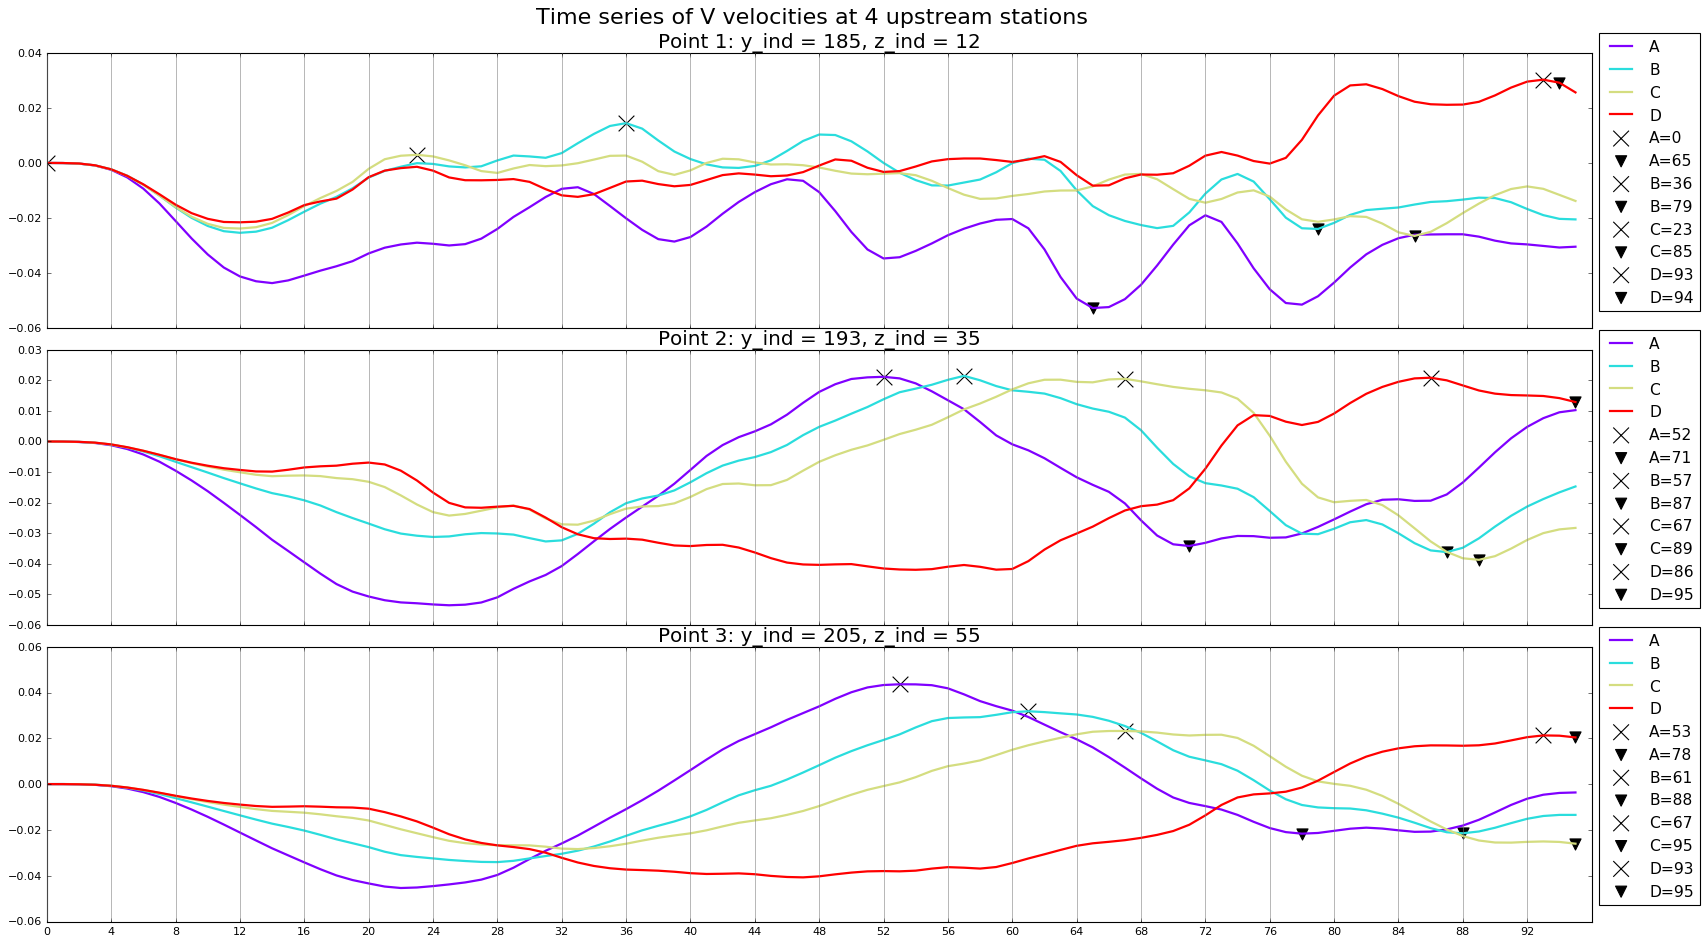

In [28]:
vels = [V_velA, V_velB, V_velC, V_velD]
fig, axes, max_vel_t_all_V, min_vel_t_all_V = plot_points_series(vels, 'V velocities', 'max', 1, 1)

#fig.savefig('../writing_images/wave_speed_fig5.png', dpi=100, bbox_inches='tight')

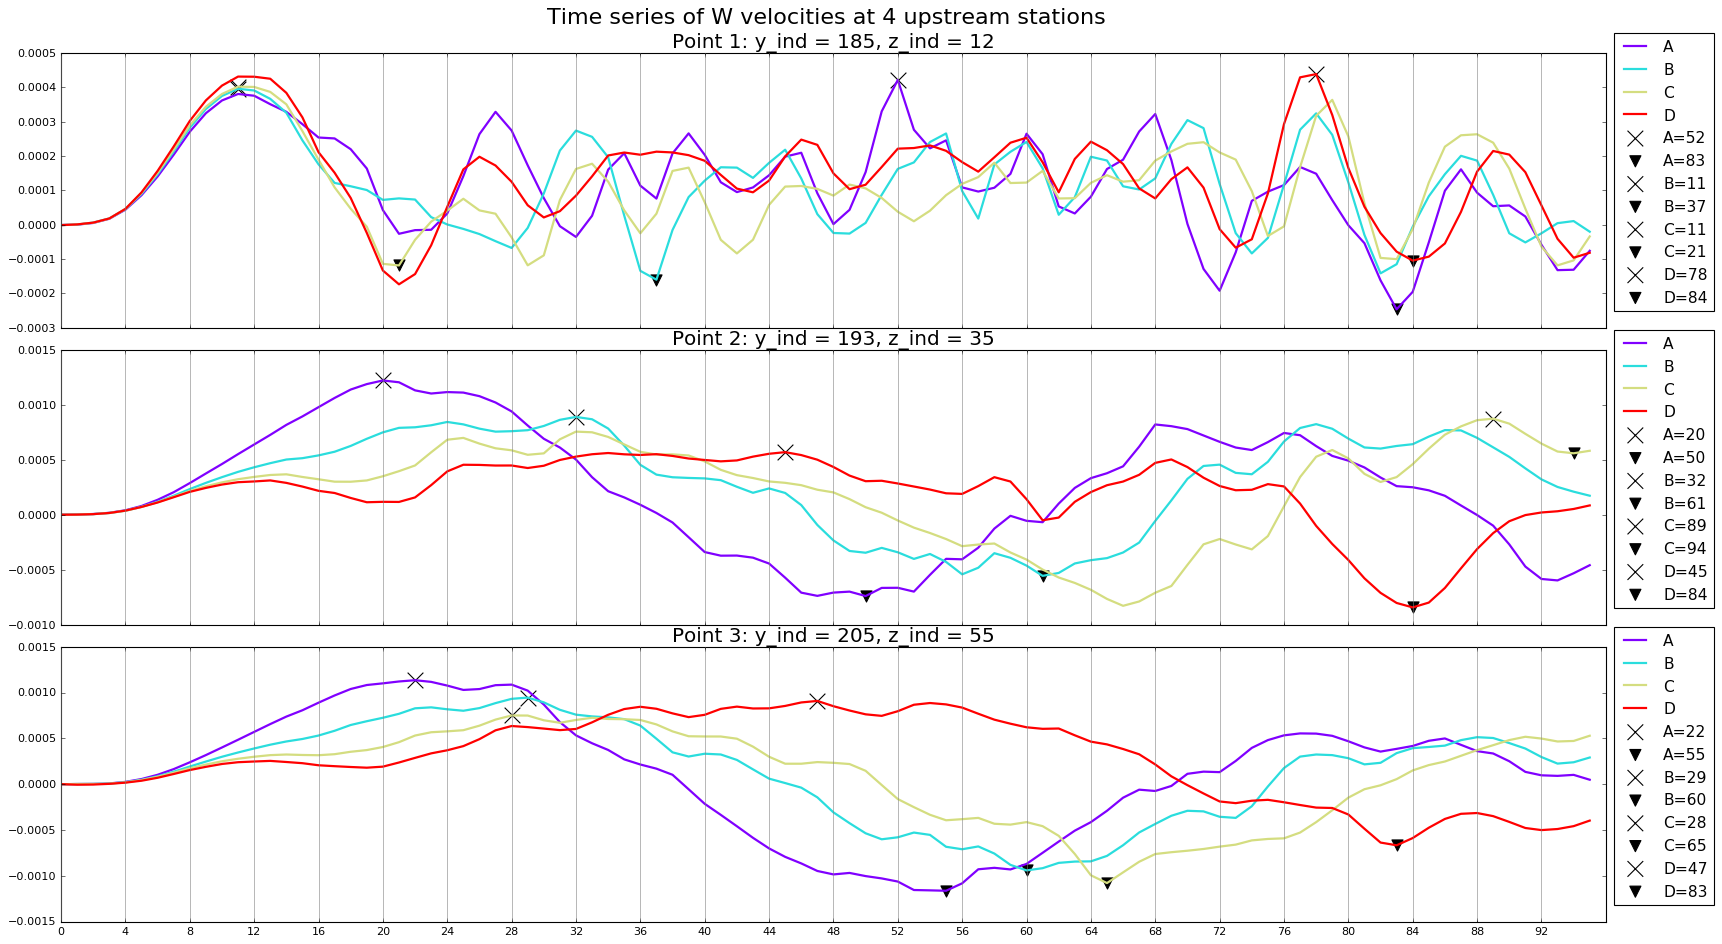

In [29]:
vels = [W_velA, W_velB, W_velC, W_velD]
fig, axes, max_vel_t_all_W, min_vel_t_all_W = plot_points_series(vels, 'W velocities', 'max', 2, 1)

#fig.savefig('../writing_images/wave_speed_fig6.png', dpi=100, bbox_inches='tight')

# Getting the distance between the 4 stations

In [18]:
mask = nc.Dataset(dirname+'1_mesh_mask.nc')
e1t_for_u = mask['e1t'][0, ...]
e1f_for_v = mask['e1f'][0, ...]
e1u_for_w = mask['e1u'][0, ...]

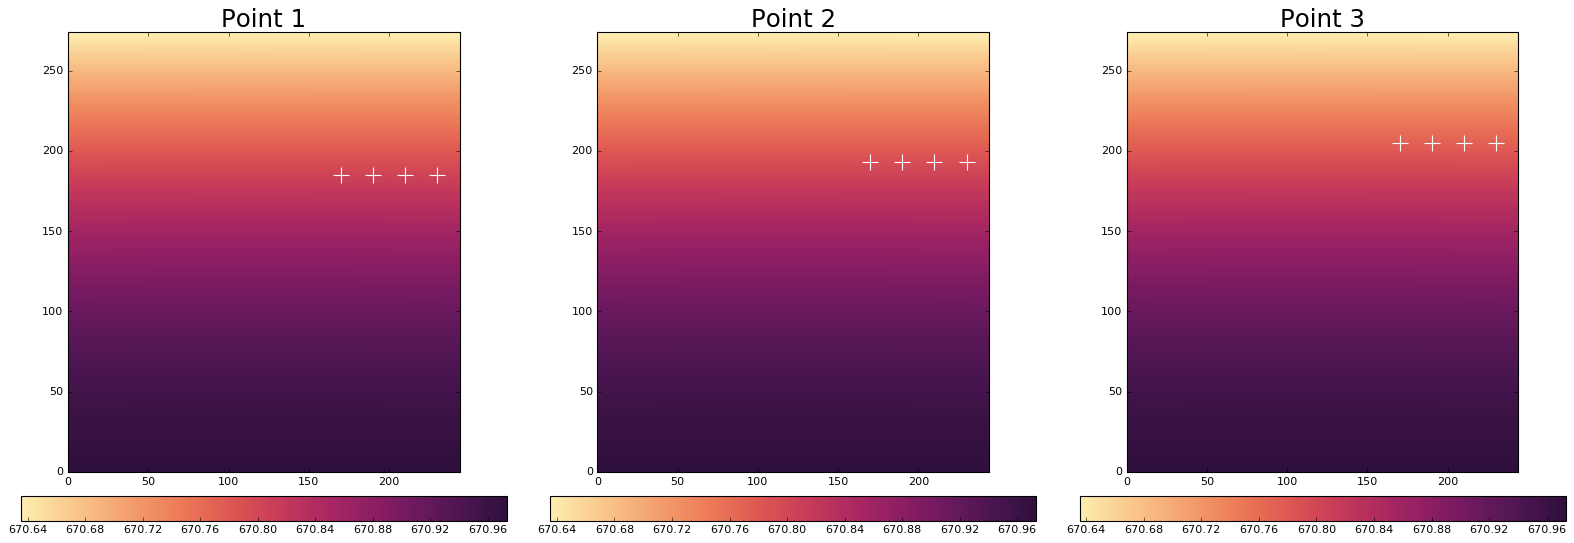

In [19]:
cell_width = e1t_for_u
npoints = np.arange(1, 4)
y_inds = [y_ind1, y_ind2, y_ind3]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.tight_layout(w_pad=0.2)
fig.tight_layout(rect=[0, 0, 1, 0.95])
for ax, n, y_ind in zip(axes.flatten(), npoints, y_inds):
    p = ax.pcolormesh(cell_width, cmap=cmo.cm.matter)
    fig.colorbar(p, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, format='%.2f')
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, cell_width.shape[-1]])
    ax.set_ylim([0, cell_width.shape[-2]])
    ax.set_title('Point ' + str(n), fontsize=22)
    ax.scatter(x_indA, y_ind, marker='+', c='w', s=200)
    ax.scatter(x_indB, y_ind, marker='+', c='w', s=200)
    ax.scatter(x_indC, y_ind, marker='+', c='w', s=200)
    ax.scatter(x_indD, y_ind, marker='+', c='w', s=200)
    
#fig.savefig('../writing_images/wave_speed_fig7.png', dpi=100, bbox_inches='tight')

In [20]:
def calculate_distance_between_stations(cell_width, y_ind1, y_ind2, y_ind3, x_indA, x_indB, x_indC, x_indD):
    
    y_inds = [y_ind1, y_ind2, y_ind3]
    
    dist_all = np.full([3, 3], np.nan)
    
    for y_ind, n in zip(y_inds, np.arange(len(y_inds))):
    
        distance_AB = np.sum(cell_width[y_ind, x_indA:x_indB])
        distance_BC = np.sum(cell_width[y_ind, x_indB:x_indC])
        distance_CD = np.sum(cell_width[y_ind, x_indC:x_indD])
        
        dist_all[n, :] = distance_AB, distance_BC, distance_CD
    
        print('For depth point ' + str(n+1) + ', the distance between stations A-B-C-D are:')
        print('distance AB = ' + str(distance_AB))
        print('distance BC = ' + str(distance_BC))
        print('distance CD = ' + str(distance_CD))
    
    return dist_all

In [21]:
cell_width = e1t_for_u

dist_all = calculate_distance_between_stations(cell_width, y_ind1, y_ind2, y_ind3, x_indA, x_indB, x_indC, x_indD)

For depth point 1, the distance between stations A-B-C-D are:
distance AB = 13416.0965755
distance BC = 13416.0950301
distance CD = 13416.0930702
For depth point 2, the distance between stations A-B-C-D are:
distance AB = 13415.8363985
distance BC = 13415.834853
distance CD = 13415.832893
For depth point 3, the distance between stations A-B-C-D are:
distance AB = 13415.4283163
distance BC = 13415.4267707
distance CD = 13415.4248106


# Getting time between the 4 stations

In [38]:
time_all_speeds_max = np.diff(max_vel_t_all_speeds) * 60 * 60
time_all_speeds_min = np.diff(min_vel_t_all_speeds) * 60 * 60

time_all_U_max = np.diff(max_vel_t_all_U) * 60 * 60
time_all_U_min = np.diff(min_vel_t_all_U) * 60 * 60

In [39]:
time_all_speeds_min

array([[ 32400.,  28800.,  10800.],
       [ 32400.,  25200.,  36000.],
       [ 57600.,  36000.,      0.]])

# Calculating velocities

In [48]:
velocity_speeds_max_all = dist_all / time_all_speeds_max
velocity_speeds_min_all = dist_all / time_all_speeds_min

velocity_U_max_all = dist_all / time_all_U_max
velocity_U_min_all = dist_all / time_all_U_min

print('Velocities between each [depth point and station]:')
print('speed: ', velocity_speeds_max_all)
print('\nspeed: ', velocity_speeds_min_all)
print('\nU: ', velocity_U_max_all)
print('\nU: ', velocity_U_min_all)

# ------------------------------------------------------

velocity_speeds_max = np.mean(dist_all / time_all_speeds_max)
velocity_speeds_min0 = dist_all / time_all_speeds_min
velocity_speeds_min = np.mean(velocity_speeds_min0[np.isfinite(velocity_speeds_min0)])

velocity_U_max0 = dist_all / time_all_U_max
velocity_U_max = np.mean(velocity_U_max0[np.isfinite(velocity_U_max0)])
velocity_U_min = np.mean(dist_all / time_all_U_min)

print('\nMean velocities:')
print('speed: ', velocity_speeds_max)
print('speed: ', velocity_speeds_min)
print('U: ', velocity_U_max)
print('U: ', velocity_U_min)

# ------------------------------------------------------

velocity_mean = np.mean([velocity_speeds_max, velocity_speeds_min, velocity_U_max, velocity_U_min])
print('\nVelocity used to extend shelf:')
print(velocity_mean)

Velocities between each [depth point and station]:
speed:  [[ 0.53238478  1.24223102  0.53238465]
 [ 0.74532424  0.4658276   1.24220675]
 [ 0.28665445  0.41405638  0.93162672]]

speed:  [[ 0.41407705  0.46583663  1.24223084]
 [ 0.41406902  0.5323744   0.37266202]
 [ 0.23290674  0.37265074         inf]]

U:  [[ 0.41407705  0.46583663  1.24223084]
 [ 0.46582765  0.4658276   0.41406892]
 [ 0.21920635  0.41405638         inf]]

U:  [[ 0.53238478  1.24223102  0.53238465]
 [ 0.93165531  0.4658276   1.24220675]
 [ 0.93162697  0.41405638  1.24216896]]

Mean velocities:
speed:  0.710299622271
speed:  0.505850932654
U:  0.512641427839
U:  0.837171379747

Velocity used to extend shelf:
0.641490840628
